In [1]:
!date

Tue Nov 29 06:03:25 EST 2022


In [2]:
pwd

'/mmfs1/data/aglinska/BC-fMRI-AE/Notebooks'

In [3]:
%%time
import numpy as np
import pandas as pd
import ants
import os

from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
from datetime import datetime; now = datetime.now;t0 = now()

CPU times: user 2.58 s, sys: 2.8 s, total: 5.38 s
Wall time: 28.1 s


In [10]:
fmriprep_dir = os.path.expanduser('~/data/sfari_bids/fmriprep')
subs = [sub for sub in os.listdir(fmriprep_dir) if sub.startswith('sub-') and not sub.endswith('.html')]
subs.sort()

In [71]:
df = pd.DataFrame(subs,columns=['subID'])
df['status'] = [os.path.exists(
                os.path.join(fmriprep_dir,
                            sub,
                            'func',
                            f'{sub}_task-rest_run-1_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz')) for sub in df['subID'].values]
df = df.iloc[df['status'].values]
df

,subID,status
0,sub-001,True
1,sub-002,True
2,sub-003,True
3,sub-005,True
4,sub-006,True
...,...,...
200,sub-204,True
201,sub-205,True
202,sub-206,True
203,sub-207,True


In [26]:
s = 0

In [27]:
subID = df['subID'].values[s]
print(subID)

sub-001


In [31]:
bids_dir = os.path.join(fmriprep_dir,subID,'func')
print(bids_dir)

/data/aglinska/data/sfari_bids/fmriprep/sub-001/func


In [32]:
files = os.listdir(bids_dir)
files = np.array(files)

files.sort()
files

array(['sub-001_task-rest_run-1_desc-confounds_timeseries.json',
       'sub-001_task-rest_run-1_desc-confounds_timeseries.tsv',
       'sub-001_task-rest_run-1_from-T1w_to-scanner_mode-image_xfm.txt',
       'sub-001_task-rest_run-1_from-scanner_to-T1w_mode-image_xfm.txt',
       'sub-001_task-rest_run-1_space-MNI152NLin2009cAsym_res-2_boldref.nii.gz',
       'sub-001_task-rest_run-1_space-MNI152NLin2009cAsym_res-2_desc-brain_mask.json',
       'sub-001_task-rest_run-1_space-MNI152NLin2009cAsym_res-2_desc-brain_mask.nii.gz',
       'sub-001_task-rest_run-1_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.json',
       'sub-001_task-rest_run-1_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz',
       'sub-001_task-rest_run-2_desc-confounds_timeseries.json',
       'sub-001_task-rest_run-2_desc-confounds_timeseries.tsv',
       'sub-001_task-rest_run-2_from-T1w_to-scanner_mode-image_xfm.txt',
       'sub-001_task-rest_run-2_from-scanner_to-T1w_mode-image_xfm.txt',
       'sub-0

In [33]:
epi_fn = files[[file.endswith('preproc_bold.nii.gz') for file in files]][0]
mask_fn = files[[file.endswith('brain_mask.nii.gz') for file in files]][0]
conf_fn = files[[file.endswith('confounds_timeseries.tsv') for file in files]][0]

In [34]:
epi_fn = os.path.join(bids_dir,epi_fn)
mask_fn = os.path.join(bids_dir,mask_fn)
conf_fn = os.path.join(bids_dir,conf_fn)

print(epi_fn)
print(mask_fn)
print(conf_fn)

/data/aglinska/data/sfari_bids/fmriprep/sub-001/func/sub-001_task-rest_run-1_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz
/data/aglinska/data/sfari_bids/fmriprep/sub-001/func/sub-001_task-rest_run-1_space-MNI152NLin2009cAsym_res-2_desc-brain_mask.nii.gz
/data/aglinska/data/sfari_bids/fmriprep/sub-001/func/sub-001_task-rest_run-1_desc-confounds_timeseries.tsv


In [35]:
epi = ants.image_read(epi_fn)
epi3d = ants.slice_image(epi,axis=3,idx=0)
mask = ants.image_read(mask_fn)
conf = pd.read_csv(conf_fn,delimiter='\t')
n = epi.shape[-1]
tr = epi.spacing[-1]
flat_epi = epi.numpy().reshape(epi.shape[-1],-1)

mean = ants.slice_image(epi,axis=3,idx=0).new_image_like(epi.numpy().mean(axis=3))
mean[mask==0]=0

data = {}
data['epi'] =epi 
data['epi3d'] = epi3d
data['mask'] = mask
data['conf'] = conf
data['mean'] = mean
data['n'] = n
data['tr'] = tr
data['flat_epi'] = flat_epi

In [36]:
def regress(flat_epi,conf,idx=None):
    from sklearn.linear_model import LinearRegression
    
#     keys = ['a_comp_cor_01', 'a_comp_cor_02','a_comp_cor_03', 
#             'a_comp_cor_04', 'a_comp_cor_05','trans_x',
#            'trans_x_derivative1', 'trans_x_derivative1_power2',
#            'trans_x_power2', 'trans_y', 'trans_y_derivative1',
#            'trans_y_power2', 'trans_y_derivative1_power2', 'trans_z',
#            'trans_z_derivative1', 'trans_z_power2',
#            'trans_z_derivative1_power2', 'rot_x', 'rot_x_derivative1',
#            'rot_x_derivative1_power2', 'rot_x_power2', 'rot_y',
#            'rot_y_derivative1', 'rot_y_derivative1_power2', 'rot_y_power2',
#            'rot_z', 'rot_z_derivative1', 'rot_z_derivative1_power2','rot_z_power2']
    
    keys = ['a_comp_cor_00', 'a_comp_cor_01','a_comp_cor_02', 
            'a_comp_cor_03', 'a_comp_cor_04','csf','white_matter']
    
    if type(idx)==type(None):
        idx = np.arange(flat_epi.shape[0])
    
    
    X = conf[keys].values[idx]
    n = X.shape[0]
    X = np.hstack((X,np.ones(n)[:,np.newaxis])) # Add mean
    X = np.hstack((X,(np.arange(n)+1)[:,np.newaxis])) # Add linear trend
    X = np.hstack((X,((np.arange(n)+1)**2)[:,np.newaxis])) # Add quadratic trend
    #X = np.hstack((X,flat_epi.mean(axis=1)[:,np.newaxis])) # Add Global signal
    X[np.isnan(X)]=0 # Fix NaNs
    
    Y_hat = LinearRegression().fit(X,flat_epi[idx,:]).predict(X) # Fit Predict 
    mat = flat_epi[idx,:] - Y_hat # Residuals
    
    return mat

In [37]:
#conf

In [38]:
def plot4d(im,axis=3,idx=0,title=None):
    ants.slice_image(im,axis=axis,idx=idx).plot_ortho(flat=True,xyz_lines=False,orient_labels=False,title=title,figsize=1.5)

In [39]:
def scrub(mat,conf,thresh):
    mat2 = mat[conf['framewise_displacement'].values>thresh,:]
    return mat2

In [40]:
def filt(im,tr,lowf=.01,highf=.1,order=3):
    imfilt = ants.bandpass_filter_matrix(im,tr=tr, lowf=lowf, highf=highf, order=order)
    return imfilt

In [41]:
def make_4depi(inmat,epi):
    'takes in samples x voxels matrix, makes a nii from it'
    #inmat = mat
    #epi = data['epi']

    arr = inmat.transpose().reshape(epi.shape[0],epi.shape[1],epi.shape[2],inmat.shape[0])
    new_im = ants.from_numpy(data=arr,origin=epi.origin,spacing=epi.spacing,direction=epi.direction,has_components=epi.has_components,is_rgb=epi.is_rgb)
    
    return new_im

In [42]:
data['epi']

ANTsImage
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (97, 115, 97, 122)
	 Spacing    : (2.0, 2.0, 2.0, 3.0)
	 Origin     : (96.5, 132.5, -78.5, 0.0)
	 Direction  : [-1.  0.  0.  0.  0. -1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.]

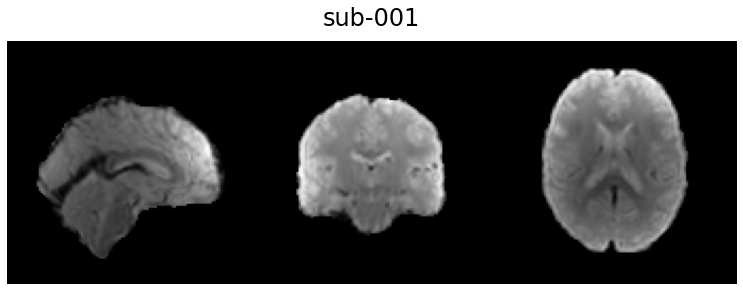

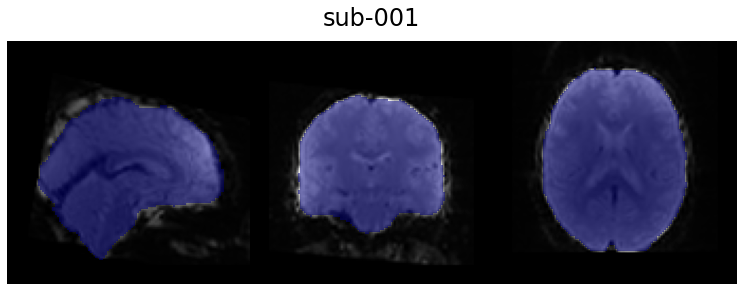

In [43]:
data['mean'].plot_ortho(flat=True,xyz_lines=False,orient_labels=False,title=subID,figsize=1.5)
data['epi3d'].plot_ortho(data['mask'],flat=True,xyz_lines=False,orient_labels=False,overlay_alpha=.5,title=subID,figsize=1.5)

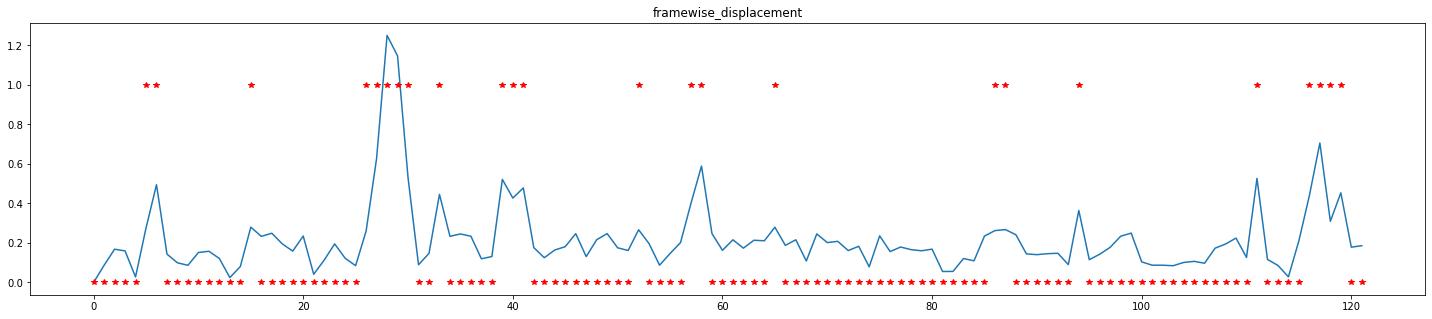

In [44]:
plt.figure(figsize=(25,5))
FD = data['conf']['framewise_displacement'].values
FD[0] = 0 # for cosmetic reasons, first value of FD is always NaN
plt.plot(FD)
plt.plot(FD>.25,'r*')
plt.title('framewise_displacement');

In [45]:
scan_time_1 = data['epi'].shape[-1]*data['tr']/60
scan_time_2 = (FD<.25).sum()*data['tr']/60
print(f'scan time {scan_time_1:.2f} minutes before scrubbing')
print(f'scan time {scan_time_2:.2f} minutes after scrubbing')

scan time 6.10 minutes before scrubbing
scan time 4.90 minutes after scrubbing


In [46]:
thresh = .25 # FD treshold

scrub_idx = data['conf']['framewise_displacement'].values > thresh

scrub_idx[0:5] = True # Drop first 5 volumes hack

epi_scrubbed = data['epi'].numpy()[:,:,:,~scrub_idx]

mat = epi_scrubbed.reshape(-1,epi_scrubbed.shape[-1]).transpose()
scrubbed_nii = make_4depi(mat,data['epi'])

rmat = regress(mat,data['conf'].iloc[~scrub_idx])

rmat_nii = make_4depi(rmat,data['epi'])
rmat_nii[data['mask'].numpy()==0]=0

In [47]:
rfmat_nii = filt(im=rmat_nii,tr=data['tr'],lowf=.01,highf=.1,order=3)
srfmat_nii = ants.smooth_image(image=rfmat_nii,sigma=4,sigma_in_physical_coordinates=True,FWHM=True,max_kernel_width=32)

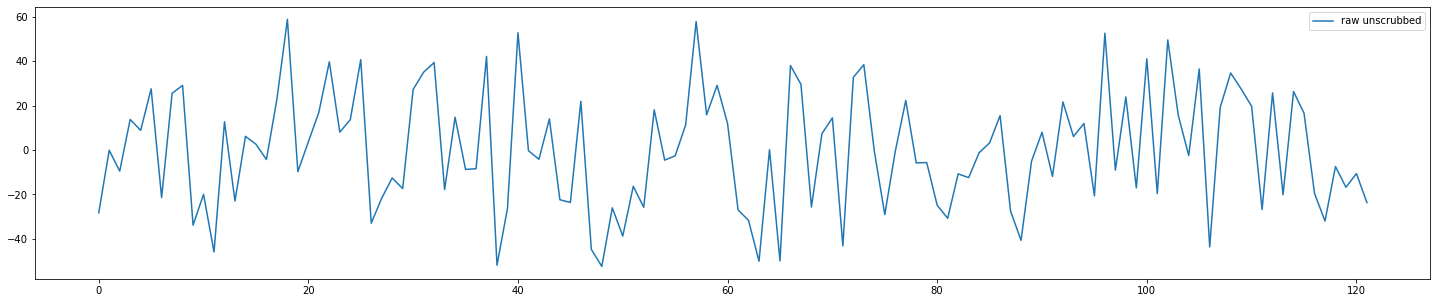

In [48]:
plt.figure(figsize=(25,5))
plt.plot(data['epi'][48,26,26,:]-data['epi'][48,26,26,:].mean())
plt.legend(['raw unscrubbed']);

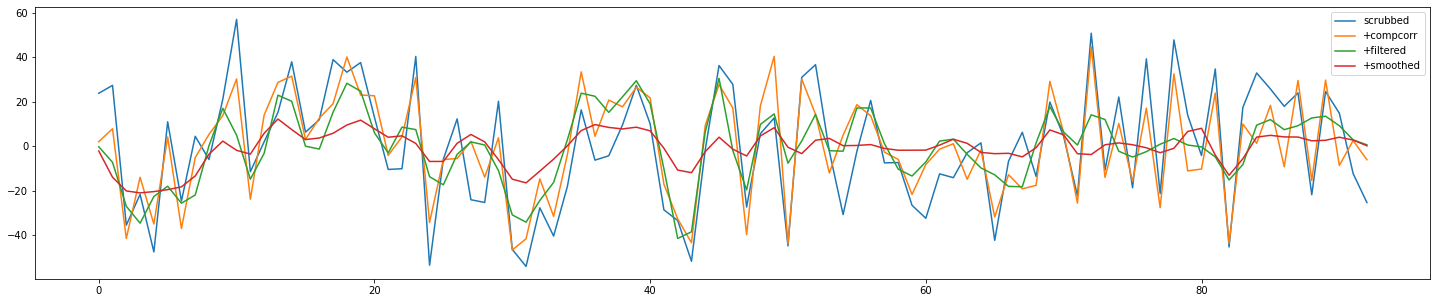

In [49]:
plt.figure(figsize=(25,5))
plt.plot(epi_scrubbed[48,26,26,:]-epi_scrubbed[48,26,26,:].mean())
plt.plot(rmat_nii.numpy()[48,26,26,:])
plt.plot(rfmat_nii.numpy()[48,26,26,:])
plt.plot(srfmat_nii.numpy()[48,26,26,:])
plt.legend(['scrubbed','+compcorr','+filtered','+smoothed']);

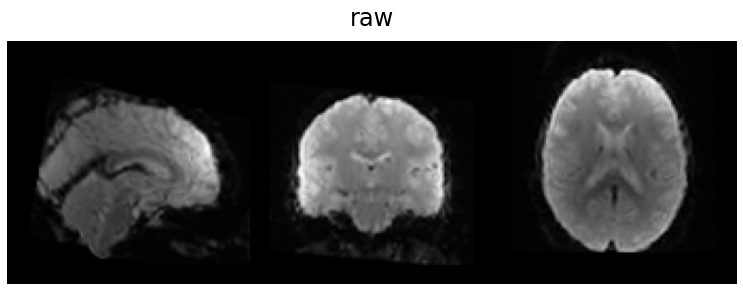

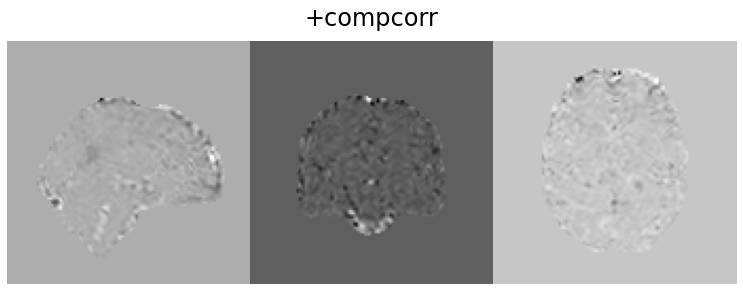

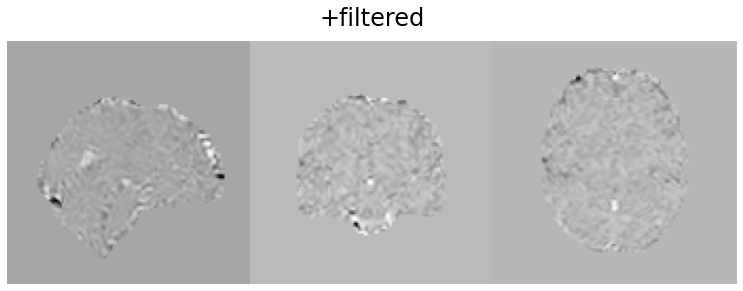

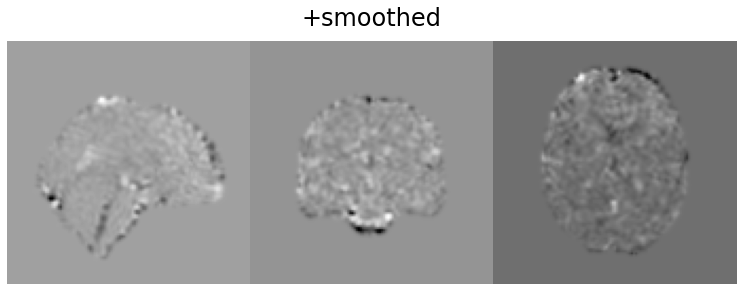

In [50]:
plot4d(data['epi'],title='raw')
plot4d(rmat_nii,title='+compcorr')
plot4d(rfmat_nii,title='+filtered')
plot4d(srfmat_nii,title='+smoothed')

In [51]:
atlas = ants.image_read('../Data/YeoAtlas/atlas_fit_91_115_97.nii.gz')
assert len(np.unique(atlas.numpy())), 'wrong atlas'

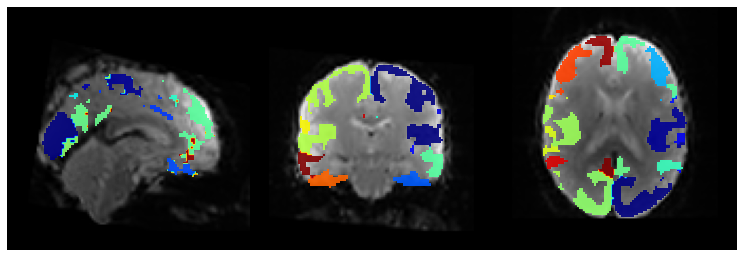

In [52]:
data['epi3d'].plot_ortho(atlas,flat=True,xyz_lines=False,orient_labels=False,figsize=1.5)

In [53]:
def get_roi_timeseries(use_mat,use_atlas):
#     use_atlas = atlas
#     use_mat = data['epi']

    assert np.isnan(use_mat.numpy()).sum()==0, 'NaNs in EPI'
    assert np.isnan(use_atlas.numpy()).sum()==0, 'NaNs in atlas'

    rois = np.arange(1,52)
    roi_timeseries = [use_mat.numpy()[use_atlas.numpy()==r].mean(axis=0) for r in rois]
    roi_timeseries = np.array(roi_timeseries)
    return roi_timeseries

In [54]:
roi_timeseries_raw = get_roi_timeseries(data['epi'],atlas)
roi_timeseries_scrubbed = get_roi_timeseries(scrubbed_nii,atlas)
roi_timeseries_rf = get_roi_timeseries(rfmat_nii,atlas)
roi_timeseries_srf = get_roi_timeseries(srfmat_nii,atlas)

cmat_raw = np.corrcoef(roi_timeseries_raw)
cmat_scrubbed = np.corrcoef(roi_timeseries_scrubbed)
cmat_rf = np.corrcoef(roi_timeseries_rf)
cmat_srf = np.corrcoef(roi_timeseries_srf)

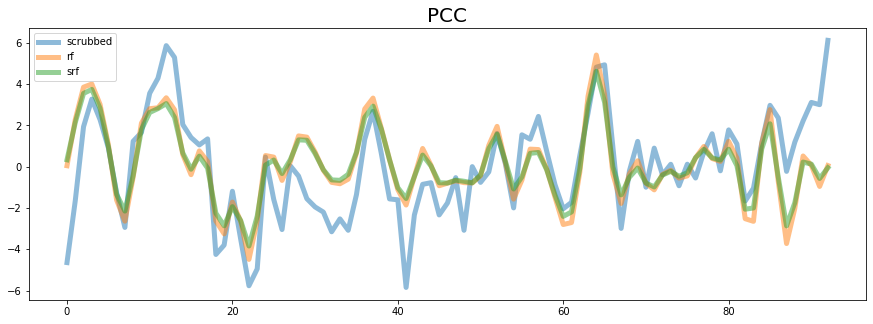

In [55]:
plt.figure(figsize=(15,5))
r = 24
plt.plot(roi_timeseries_scrubbed[r,:]-roi_timeseries_scrubbed[r,:].mean(),linewidth=5,alpha=.5)
plt.plot(roi_timeseries_rf[r,:],linewidth=5,alpha=.5)
plt.plot(roi_timeseries_srf[r,:],linewidth=5,alpha=.5)
plt.legend(['scrubbed','rf','srf'])
plt.title('PCC',fontsize=20);

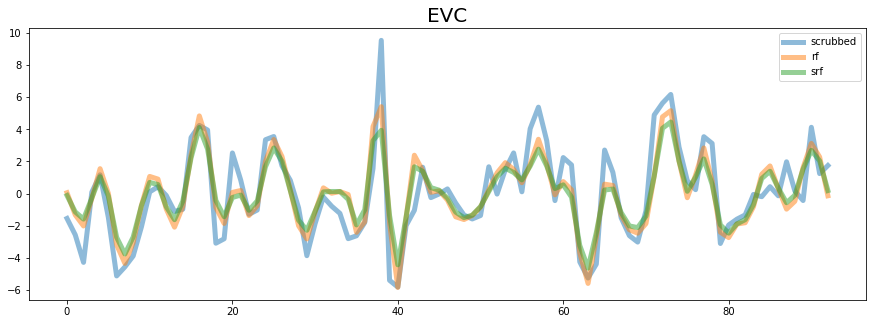

In [56]:
plt.figure(figsize=(15,5))
r = 0
plt.plot(roi_timeseries_scrubbed[r,:]-roi_timeseries_scrubbed[r,:].mean(),linewidth=5,alpha=.5)
plt.plot(roi_timeseries_rf[r,:],linewidth=5,alpha=.5)
plt.plot(roi_timeseries_srf[r,:],linewidth=5,alpha=.5)
plt.legend(['scrubbed','rf','srf'])
plt.title('EVC',fontsize=20);

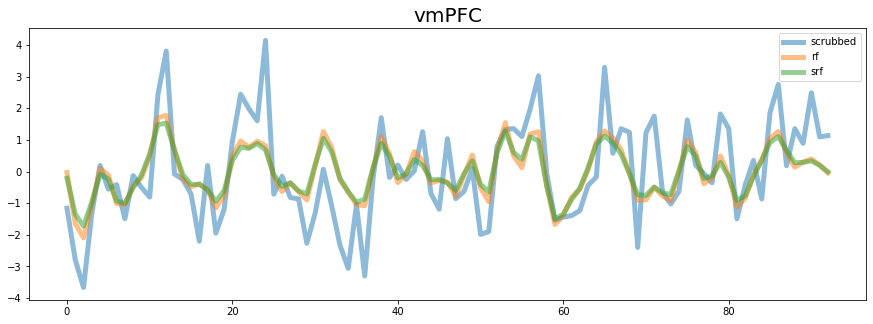

In [57]:
plt.figure(figsize=(15,5))
r = 11
plt.plot(roi_timeseries_scrubbed[r,:]-roi_timeseries_scrubbed[r,:].mean(),linewidth=5,alpha=.5)
plt.plot(roi_timeseries_rf[r,:],linewidth=5,alpha=.5)
plt.plot(roi_timeseries_srf[r,:],linewidth=5,alpha=.5)
plt.legend(['scrubbed','rf','srf'])
plt.title('vmPFC',fontsize=20);

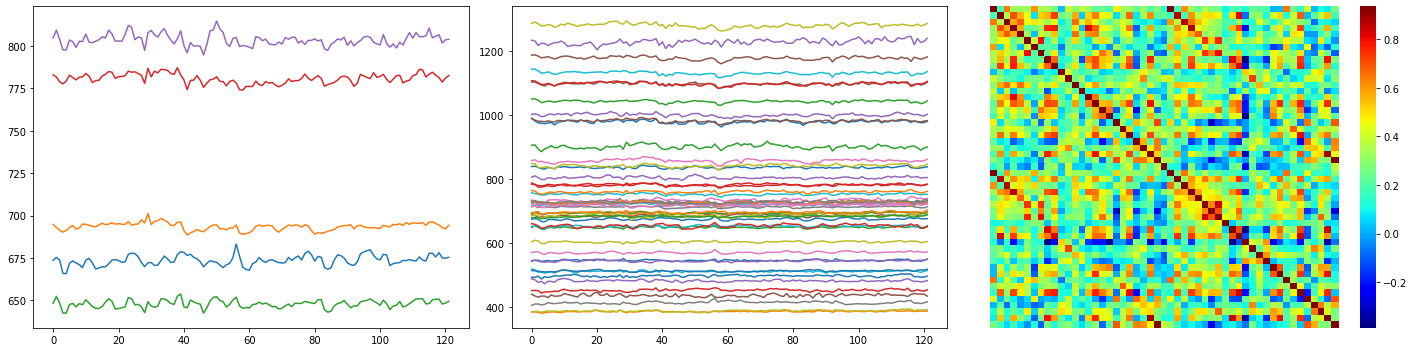

In [58]:
mat = roi_timeseries_raw
cmat = np.corrcoef(mat)
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.plot(mat[0:5,:].transpose())
plt.subplot(1,3,2)
plt.plot(mat[:,:].transpose());
plt.subplot(1,3,3)
sns.heatmap(cmat,xticklabels=[],yticklabels=[],cmap='jet',vmin=cmat[np.triu_indices(51,1)].min(),vmax=cmat[np.triu_indices(51,1)].max())
plt.tight_layout()

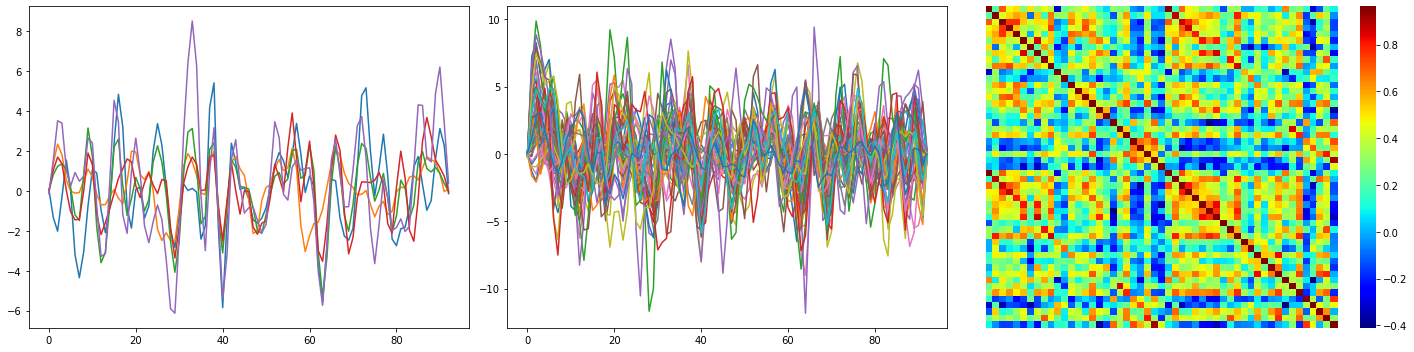

In [59]:
roi_timeseries_rfmat = get_roi_timeseries(rfmat_nii,atlas)

mat = roi_timeseries_rfmat
cmat = np.corrcoef(mat)
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.plot(mat[0:5,:].transpose())
plt.subplot(1,3,2)
plt.plot(mat[:,:].transpose());
plt.subplot(1,3,3)
sns.heatmap(cmat,xticklabels=[],yticklabels=[],cmap='jet',vmin=cmat[np.triu_indices(51,1)].min(),vmax=cmat[np.triu_indices(51,1)].max())
plt.tight_layout()

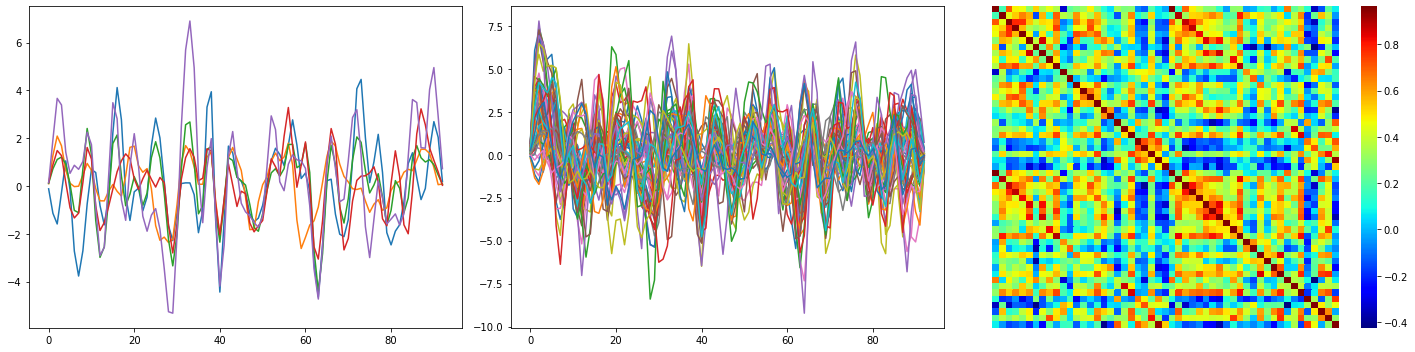

In [60]:
roi_timeseries_srfmat = get_roi_timeseries(srfmat_nii,atlas)

mat = roi_timeseries_srfmat
cmat = np.corrcoef(mat)
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.plot(mat[0:5,:].transpose())
plt.subplot(1,3,2)
plt.plot(mat[:,:].transpose());
plt.subplot(1,3,3)
#plt.imshow(cmat);
sns.heatmap(cmat,xticklabels=[],yticklabels=[],cmap='jet',vmin=cmat[np.triu_indices(51,1)].min(),vmax=cmat[np.triu_indices(51,1)].max())
plt.tight_layout()



In [61]:
ofdir = os.path.expanduser('~/BC-fMRI-AE/Assets/data_preprocessed_sfari-run1')

if not os.path.exists(ofdir):
    os.mkdir(ofdir)
    
subdir = os.path.join(ofdir,f'{subID}')
if not os.path.exists(subdir):
    os.mkdir(subdir)

In [62]:
%%time
data['epi'].to_filename(os.path.join(subdir,f'raw-{subID}_bold.nii.gz'))
data['mask'].to_filename(os.path.join(subdir,f'mask-{subID}_bold.nii.gz'))
rmat_nii.to_filename(os.path.join(subdir,f'rc-{subID}_bold.nii.gz'))
rfmat_nii.to_filename(os.path.join(subdir,f'frc-{subID}_bold.nii.gz'))
srfmat_nii.to_filename(os.path.join(subdir,f'sfrc-{subID}_bold.nii.gz'))
data['mean'].to_filename(os.path.join(subdir,f'mean-{subID}_bold.nii.gz'))
data['conf'].to_csv(os.path.join(subdir,f'conf-{subID}.csv'))
atlas.to_filename(os.path.join(subdir,f'atlas-{subID}.nii.gz'))
np.save(os.path.join(subdir,f'scan_duration_{subID}.npy'),scan_time_2)

CPU times: user 34.1 s, sys: 395 ms, total: 34.5 s
Wall time: 44.2 s


In [63]:
np.save(os.path.join(subdir,f'roi_timeseries_raw_{subID}.npy'),roi_timeseries_raw)
np.save(os.path.join(subdir,f'roi_timeseries_scrubbed_{subID}.npy'),roi_timeseries_scrubbed)
np.save(os.path.join(subdir,f'roi_timeseries_rf_{subID}.npy'),roi_timeseries_rf)
np.save(os.path.join(subdir,f'roi_timeseries_srf_{subID}.npy'),roi_timeseries_srf)

In [64]:
np.save(os.path.join(subdir,f'cmat_raw_{subID}.npy'),cmat_raw)
np.save(os.path.join(subdir,f'cmat_scrubbed_{subID}.npy'),cmat_scrubbed)
np.save(os.path.join(subdir,f'cmat_rf_{subID}.npy'),cmat_rf)
np.save(os.path.join(subdir,f'cmat_srf_{subID}.npy'),cmat_srf)

In [65]:
def get_split_data(im):
    mid = int(im.shape[-1]/2)
    first_half = im.numpy()[:,:,:,0:(mid-1)]
    second_half = im.numpy()[:,:,:,mid+1::]

    rois = np.arange(1,52)
    roi_timeseries1 = np.array([first_half[atlas.numpy()==r].mean(axis=0) for r in rois])
    roi_timeseries2 = np.array([second_half[atlas.numpy()==r].mean(axis=0) for r in rois])
    cmat1 = np.corrcoef(roi_timeseries1)
    cmat2 = np.corrcoef(roi_timeseries2)

    return roi_timeseries1,roi_timeseries2,cmat1,cmat2

In [66]:
roi_timeseries1,roi_timeseries2,cmat1,cmat2 = get_split_data(data['epi'])
np.savez_compressed(os.path.join(subdir,f'split_data_raw{subID}.npz'),
                    roi_timeseries1=roi_timeseries1,
                   roi_timeseries2=roi_timeseries2,
                   cmat1=cmat1,
                   cmat2=cmat2)

In [67]:
roi_timeseries1,roi_timeseries2,cmat1,cmat2 = get_split_data(rfmat_nii)
np.savez_compressed(os.path.join(subdir,f'split_data_rf{subID}.npz'),
                    roi_timeseries1=roi_timeseries1,
                   roi_timeseries2=roi_timeseries2,
                   cmat1=cmat1,
                   cmat2=cmat2)

In [68]:
roi_timeseries1,roi_timeseries2,cmat1,cmat2 = get_split_data(rmat_nii)
np.savez_compressed(os.path.join(subdir,f'split_data_rc{subID}.npz'),
                    roi_timeseries1=roi_timeseries1,
                   roi_timeseries2=roi_timeseries2,
                   cmat1=cmat1,
                   cmat2=cmat2)

In [69]:
roi_timeseries1,roi_timeseries2,cmat1,cmat2 = get_split_data(srfmat_nii)
np.savez_compressed(os.path.join(subdir,f'split_data_srf{subID}.npz'),
                    roi_timeseries1=roi_timeseries1,
                   roi_timeseries2=roi_timeseries2,
                   cmat1=cmat1,
                   cmat2=cmat2)

In [70]:
!date

Tue Nov 29 06:18:20 EST 2022
